# Evoluční algoritmy - Genetické programování

Dneska se podíváme na jednoduché genetické programování. Vyzkoušíme si ho na problému symbolické regrese, kdy bude naším cílem nalézt vzoreček, který bude nejlépe odpovídat zadaným datům, a klasifikace, kdy budeme hledat rozhodovací strom pomocí genetického programování.

K tomuto budeme používat knihovnu deap, kterou jsme si ukázali minule.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pydot
from IPython.display import Image

import operator
from deap import gp
from deap import creator, base, tools, algorithms

import pydot
from IPython.display import Image

Nejprve si vygenerujeme data v nějakém rozumném rozsahu a k nim odpovídající labely, například pomocí funkce sinus. Pro ně pak budeme chtít najít vzoreček regrese, který jim bude nejlépe odpovídat.

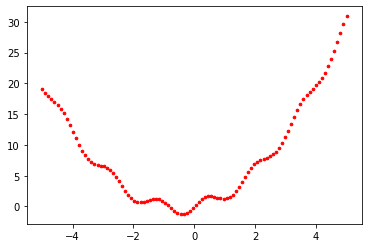

In [2]:
x_train = np.linspace(-5, 5, 100)
y_train = x_train*x_train + x_train + np.sin(4*x_train)

plt.scatter(x_train, y_train,s=7,c='r')
plt.show()

Pro práci s genetickým algoritmem budeme potřebovat vyvořit množinu terminálů a neterminálů, se kterými bude evoluce pracovat. K tomu v knihovně deap existuje třída `gp.PrimitiveSet`, případně `gp.PrimitiveSetTyped` pro typované GP. V našem příkladu použijeme tu typovanou verzi, protože je obecnější. Jelikož ale budeme používat jen jeden typ jedinců, šla by použít i netypovaná verze. Jako terminály si definujeme konstanty 0,1,2, zbytek se dovytvoří z nich během evoluce. Jako neterminály budeme potřebovat operace sčítání, násobení a sinus, a protože zbylé operace se ve vzorečku nevyskytují, nebudeme si jimi zbytečně komplikovat život.

In [3]:
# mnozina se jmenuje MAIN, vstup je jeden float, vystup je taky jeden float
pset = gp.PrimitiveSetTyped('MAIN', [float], float) 

# terminaly
pset.addTerminal(1.0, float)
pset.addTerminal(2.0, float)
pset.addTerminal(0.0, float)


# neterminaly
pset.addPrimitive(np.sin, [float], float)
pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)
#pset.addPrimitive(operator.sub, [float, float], float)
#pset.addPrimitive(np.cos, [float], float)
#pset.addPrimitive(operator.truediv, [float, float], float)

Když máme vytvořené terminály a neterminály, můžeme si definovat jedince, fitness funkci a genetické operátory. Jedince vygenerujeme jako náhodné stromy z množiny primitiv a nastavíme jim počáteční minimální a maximální hloubku. Fitness funkce bude MSE (Mean Squared Error), která počítá střední hodnoty druhých mocnin rozdílů mezi predikovanou výstupní hodnotou a skutečnou výstupní hodnotou, tedy čtvercovou vzdálenost jak daleko je predikovaný výstup od skutečného. Nastavíme jí váhu -1, protože chceme chybu minimalizovat. Zároveň nastavíme i váhu -0.01, která penalizuje počet uzlů ve stromu, abychom evoluci nutili k vytváření spíše menších jedinců. Selekci použijeme turnajovou, křížení jednobodové, kdy se klasicky náhodně zvolí bod a v něm se prohodí části podstromů, a uniformní mutaci, která náhodně vybere místo v jedinci a nahradí podstrom za kořen výrazu vygenerovanou pomocí metody ```expr()``` na základě definovaných operací a konstant. Zároveň přidáme limity na hloubku stromu pri křížení a mutaci, aby nám stromy zbytečně nebobtnaly.

In [4]:
# definujeme fitness 
def fitness(ind, x, y):
    func = toolbox.compile(expr=ind) # vytvorime funkci podle jedince
    vals = list(map(func, x)) # zavolame funkci na data
    return np.sqrt(np.dot(vals-y, vals-y)), len(ind) #spocitame chybu pomoci MSE

# vytvorime tridy pro jedince
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -0.01))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# nastavime algoritmus
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, type_=float, min_=3, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", fitness, x=x_train, y=y_train)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset) 

# limity na hloubku stromu
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

Nyní jsme si napsali všechny potřebné operátory a definovali jsme si populaci, tak si ještě dodefinujeme nějaké statistické metody, abychom mohli sledovat vývoj evoluce a pak můžeme náš algoritmus genetického programování pustit.

In [9]:
pop = toolbox.population(n=1000)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 100, stats=mstats, halloffame=hof, verbose=True)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max   	min   	nevals	std    	avg   	gen	max	min	nevals	std    
0  	1000  	526.616	0  	152403	20.651	1000  	5646.46	71.981	0  	766	4  	1000  	119.423
1  	600   	111.029	1  	2148.51	9.97719	600   	67.6148	44.703	1  	646	2  	600   	81.3179
2  	562   	103.546	2  	1329.81	9.97719	562   	65.7272	32.326	2  	612	2  	562   	59.3192
3  	565   	86.6497	3  	953.035	7.03293	565   	50.2152	32.963	3  	533	2  	565   	54.6229
4  	521   	79.2172	4  	2277.04	7.03293	521   	114.981	36.048	4  	372	3  	521   	59.2008
5  	494   	63.3151	5  	1408.42	7.03293	494   	96.2799	30.488	5  	372	2  	494   	50.7002
6  	557   	70.3248	6  	9874.78	7.03293	557   	326.472	22.592	6  	372	2  	557   	25.7803
7  	547   	62.6065	7  	2847.05	0.881457	547   	169.092	20.234	7  	342	3  	547   	14.32

89 	542   	62.8968	89 	6246.57	7.03293 	542   	228.777	5.493 	89 	19 	2  	542   	2.05425
90 	570   	61.9638	90 	2287.6 	7.03293 	570   	142.572	5.372 	90 	20 	2  	570   	1.9083 
91 	541   	61.2528	91 	7050.89	7.03293 	541   	248.258	5.489 	91 	21 	2  	541   	2.09282
92 	572   	62.4696	92 	1642.41	7.03293 	572   	138.117	5.499 	92 	18 	2  	572   	2.07268
93 	599   	61.3369	93 	1031.99	7.03293 	599   	123.201	5.605 	93 	19 	2  	599   	2.27266
94 	522   	66.0633	94 	774.356	7.03293 	522   	131.516	5.398 	94 	21 	2  	522   	1.92966
95 	556   	62.6563	95 	4225.81	7.03293 	556   	177.862	5.441 	95 	19 	2  	556   	1.99562
96 	550   	61.4545	96 	500.072	7.03293 	550   	122.409	5.34  	96 	18 	2  	550   	1.84835
97 	570   	61.7248	97 	1950.43	7.03293 	570   	137.028	5.382 	97 	24 	2  	570   	1.92875
98 	552   	55.9476	98 	535.452	7.03293 	552   	112.98 	5.385 	98 	18 	2  	552   	1.7991 
99 	561   	53.923 	99 	526.258	7.03293 	561   	110.786	5.366 	99 	18 	2  	561   	1.85743
100	586   	64.4367	10

Vidíme, že výstup výše je sice krásný a určitě bohatě vypovídající, ale asi bychom víc ocenili nějakou vizualici. Proto si napíšeme pomocnou funkci na zobrazení vytvořeného stromu. To uděláme pomocí knihovny *pydot*, která slouží právě ke zobrazování grafů.

In [10]:
# zobrazeni jedince jako stromu
def plot_tree(tree):
    nodes, edges, labels = gp.graph(tree)
    nodesDot = list(map(lambda x: pydot.Node(x, label=str(labels.get(x))),nodes))

    g = pydot.Dot(graph_type='graph')
    for node in nodesDot:
        g.add_node(node)
    for f,t in edges:
        edge = pydot.Edge(nodesDot[f], nodesDot[t])
        g.add_edge(edge)

    return g.create_png()

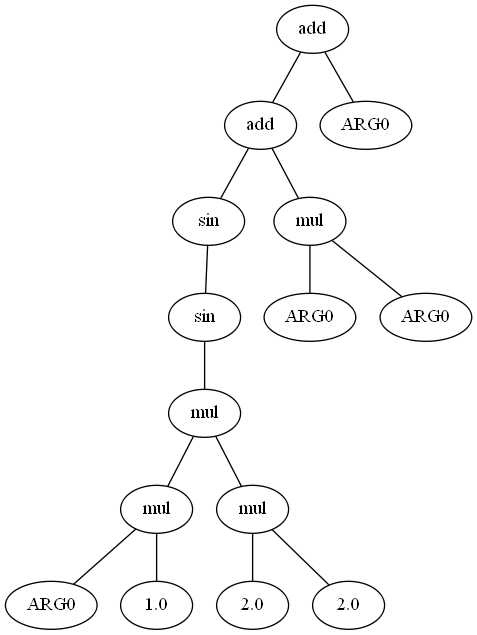

In [11]:
Image(plot_tree(hof[0]))

Ještě si napíšeme jednoduchou funkci, která nám vykreslí graf, abychom se mohli podívat, jak vypadá naše naučená funkce vzhledem k datům. Když máme štěstí na dobrý běh tak vidíme, že se nám podařilo nalézt funkci téměř ideálně pasující na naše data.

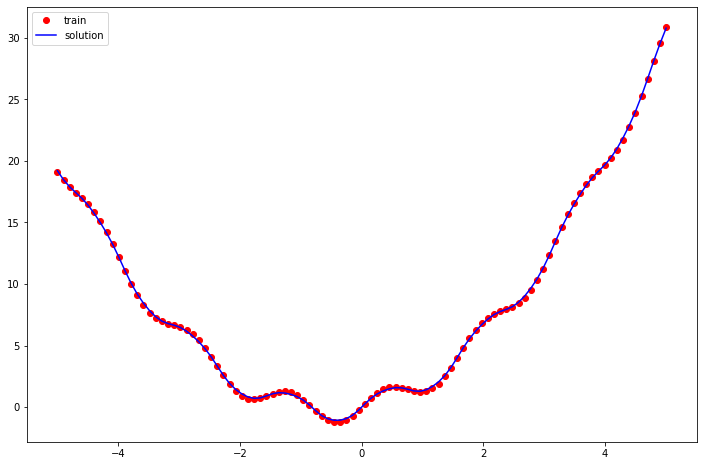

In [12]:
sol = gp.compile(hof[0], pset)

y = list(map(sol, x_train))
plt.figure(figsize=(12, 8))
plt.plot(x_train, y_train, 'ro', label='train')
plt.plot(x_train, y, 'b',label='solution')
plt.legend()
plt.show()

## Úkol na cvičení

Zkuste pomocí genetického programování řešit problém klasifikace pro dataset Iris, se kterým jsme pracovali na prvním cvičení. Promyslete si, jak definovat množinu primitiv a fitness. Následně je naimplementujte je a pusťte genetické programování.